# Checking QC benchmarks for LISST data

LISST data can be evaluated for quality independently of comparison with another co-located dataset.
<ul>
    <li>Optical Transmission - Data is valid between ### and 99.5%. Data is suspect below 30%.</li>
    <li>Beam Attenuation - Should be greater than or equal to zero.</li>
</ul>

### Initialize the workspace

In [1]:
from os import path
import glob
import re
import cmocean.cm as cmo

import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

%matplotlib inline

In [2]:
# Load LISST CSV column names from json containing column headers
headers = pd.read_json("./inst_headers/lisst_hdr.json", typ='series', orient='records')
csvhdr = headers.iloc[0]

In [6]:
# Define functions
def load_lisst(castnum, csvhdr, leg='a'):
    # Define paths to data
    lisst_path = "D:/LISST_PRTSZ/Pioneer21_AR87_PRTSZ_data"
    data_path = f"AR87{leg}_CAST{castnum}_*/*.csv"
    # Load processed LISST data
    for f in glob.glob(path.join(lisst_path, data_path)):
        lisst_data = pd.read_csv(f, names=csvhdr)
        try: lisst_data.head(1) 
        except: print("No LISST data for this cast.")
    # Create LISST time vectors for Xarray Dataset coordinates
    lisst_time = pd.to_datetime(lisst_data[["year", "month", "day", "hour", "minute", "second"]], yearfirst=True, utc=True)
    lisst_data.insert(0, "time", lisst_time.values)
    lisst_data.set_index("time", drop=True, inplace=True)
    # print(lisst_data.head(1))
    # Convert data frames to xarray for easy manipulation
    lisst_ds = xr.Dataset.from_dataframe(lisst_data)
    return lisst_ds

def optical_transmission_plot(ds, castnum):
    fig, ax = plt.subplots()
    optical_transmission = ds["optical_transmission"]*100
    optical_transmission = optical_transmission.where(ds["depth"]>=0, np.nan)
    # color = xr.ones_like(optical_transmission,).where(optical_transmission.values>100, -1).where(cast23_ds["depth"]>=0, drop=True)
    # optical_transmission.plot.scatter(c=color, cmap=colormap, edgecolors='None', )
    optical_transmission.plot()
    [xmin, xmax] = ax.get_xlim()
    ax.hlines(100, xmin, xmax, "r", linestyles="dashed")
    ax.set_xlim([xmin, xmax])
    ax.grid()
    ax.set_ylabel("Optical Transmission [%]")
    ax.set_xlabel("Time")
    ax.set_title(f"Cast {castnum}")
    return fig, ax


### Create simple plots 

In [4]:
# Load data for cast 023 on AR87b
cast23_ds = load_lisst('023', csvhdr, leg='b')
cast23_ds

<xarray.Dataset> Size: 691kB
Dimensions:               (time: 1394)
Coordinates:
  * time                  (time) datetime64[ns] 11kB 2025-04-15T14:02:45 ... ...
Data variables: (12/61)
    volumecon1            (time) float64 11kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    volumecon2            (time) float64 11kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    volumecon3            (time) float64 11kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    volumecon4            (time) float64 11kB 0.0 0.0 0.0 ... 0.0231 0.0253
    volumecon5            (time) float64 11kB 0.0 0.0 0.0 ... 8.969 8.558 9.391
    volumecon6            (time) float64 11kB 0.0 0.0 0.0 ... 269.6 254.2 278.1
    ...                    ...
    rawpressure1          (time) int64 11kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    rawpressure2          (time) int64 11kB 22413 22408 22407 ... 22411 22411
    ambient_light         (time) int64 11kB 500 530 505 513 ... 200 216 228 241
    ext_in3               (time) float64 11kB 0.011 1.371 1.437 ... 0.562 0.561
    optical_transmission  (time) float64 11kB 0.872 0.867 0.868 ... 0.012 0.011
    beam_attenuation      (time) float64 11kB 5.494 5.704 5.661 ... 176.7 179.9

In [5]:
colormap = cmo.balance

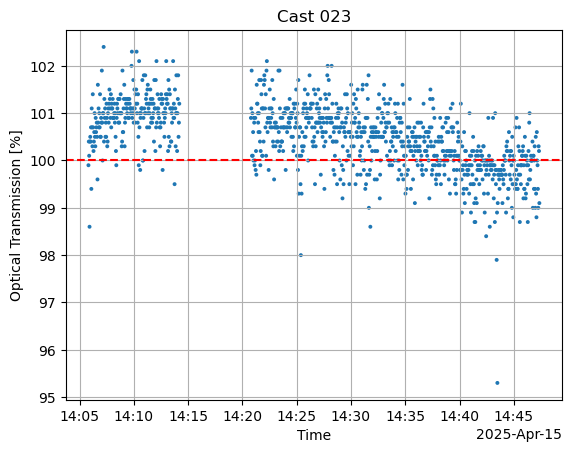

In [20]:
# Plot optical transmission as a percentage
leg = "b"
castnum = "23".rjust(3,"0")
fig, ax = optical_transmission_plot(cast23_ds, castnum)
fig.savefig(f"./figures/ar87{leg}_cast{castnum}_lisst_transmission.png")

C:\Users\kylene.cooley\AppData\Local\Temp\ipykernel_22780\2106117954.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


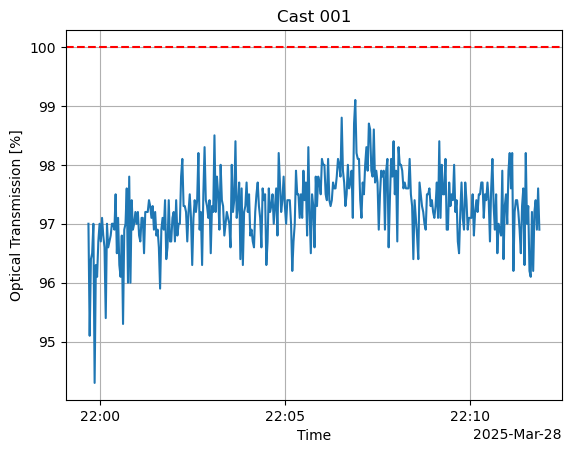

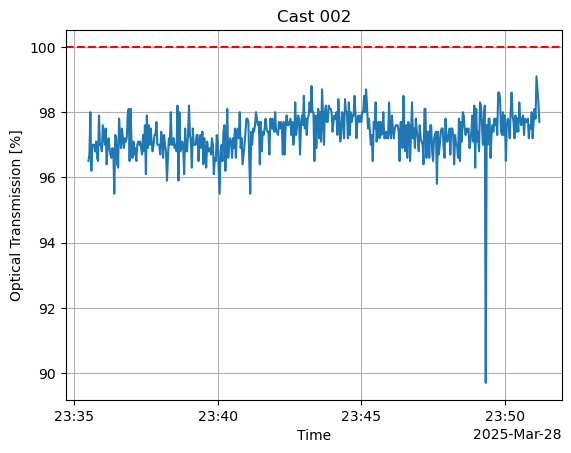

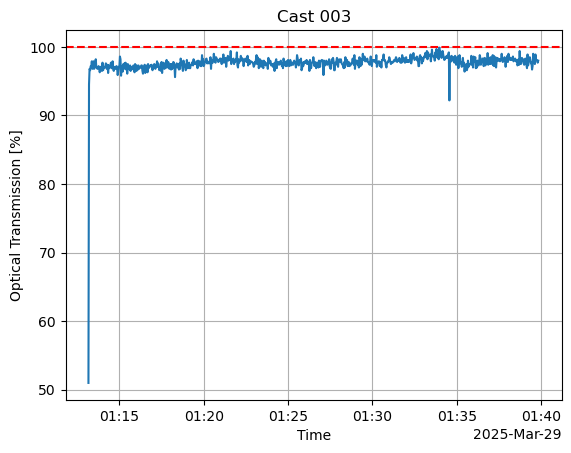

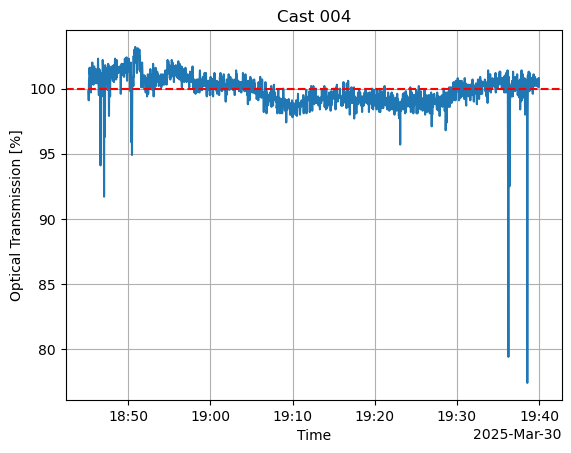

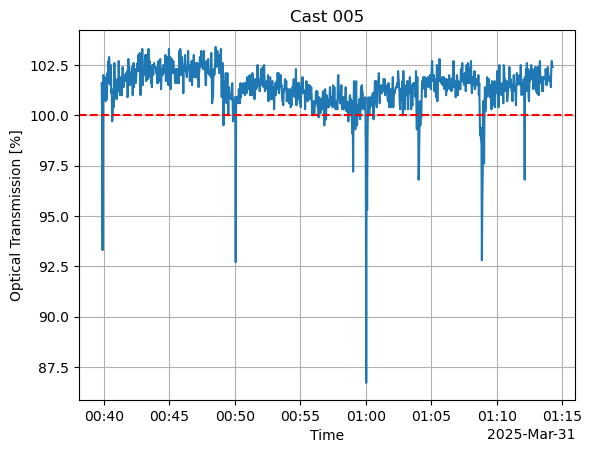

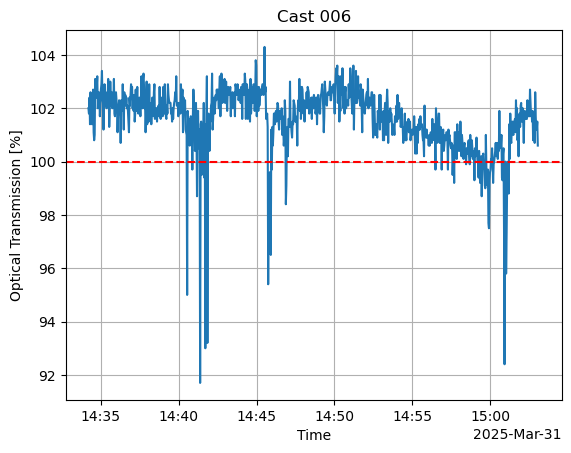

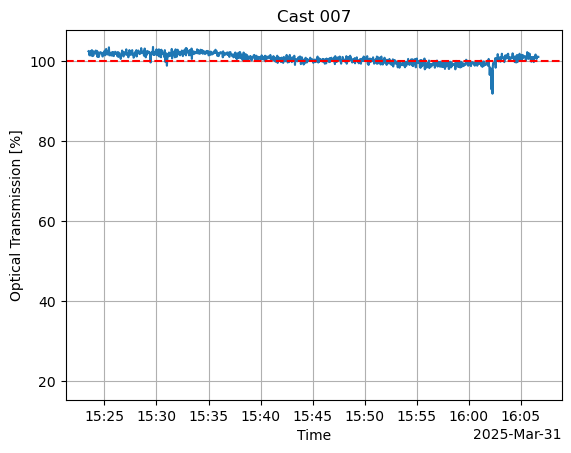

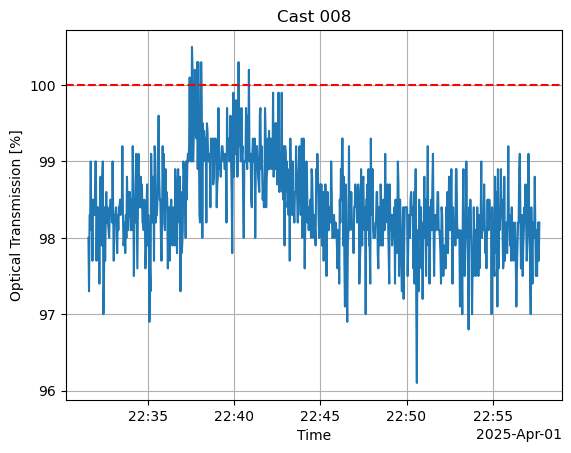

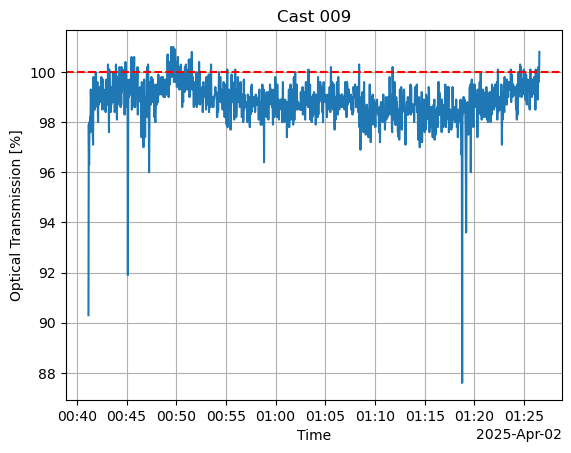

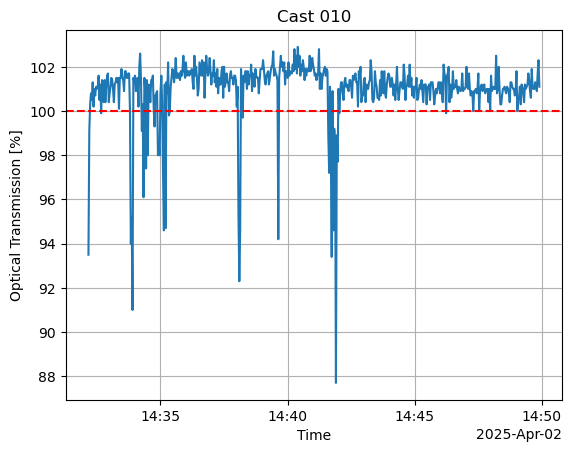

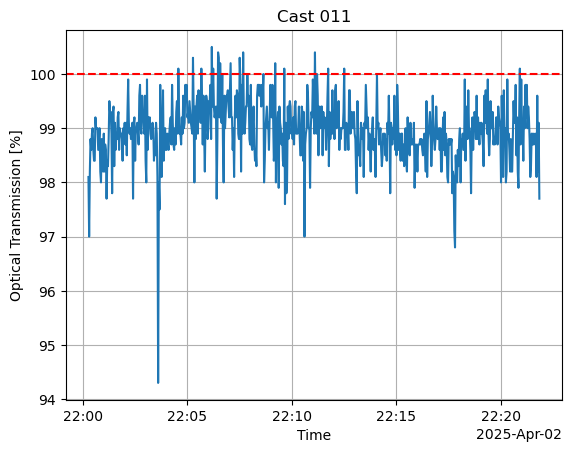

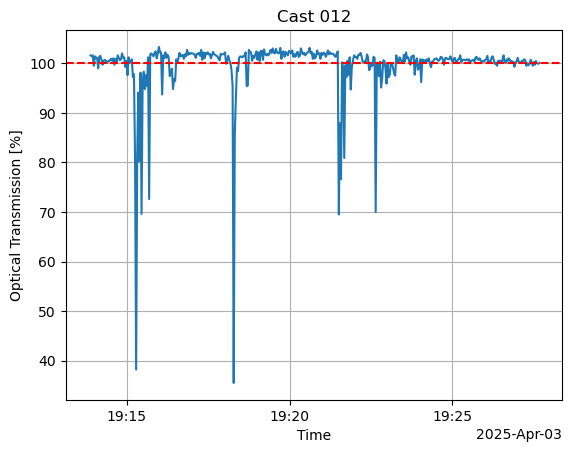

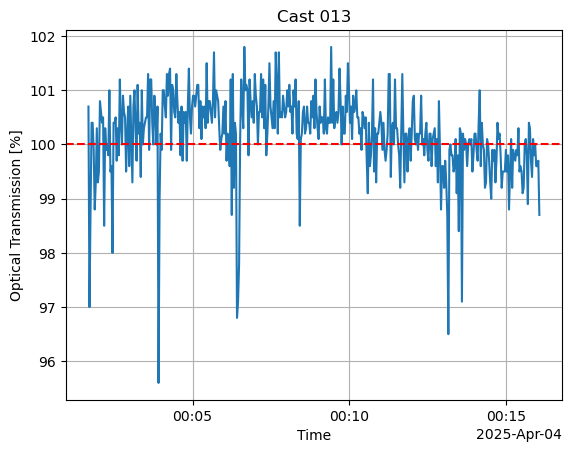

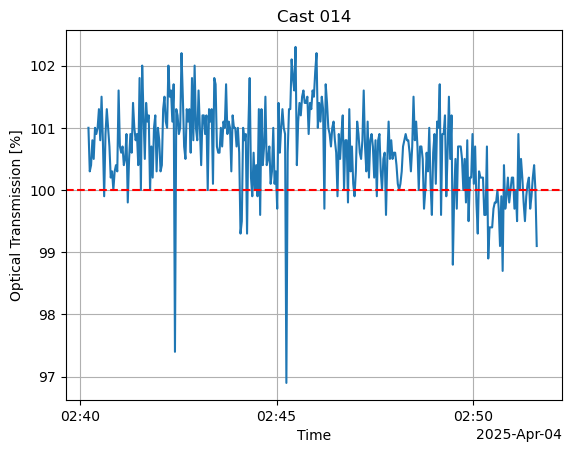

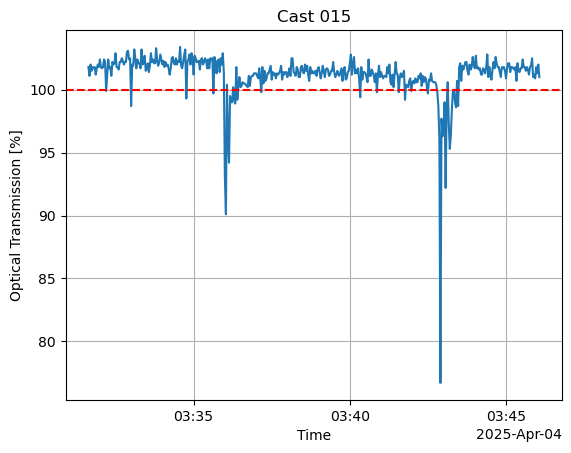

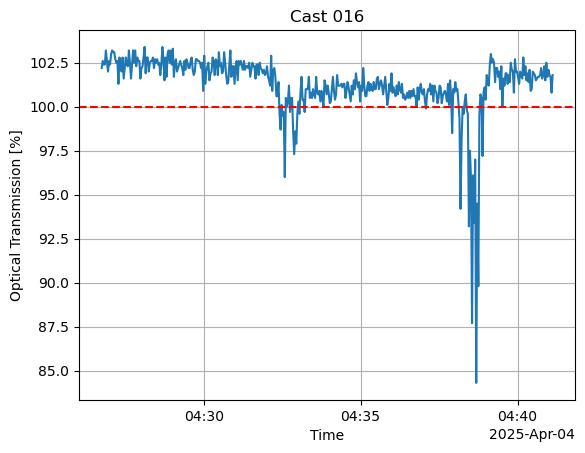

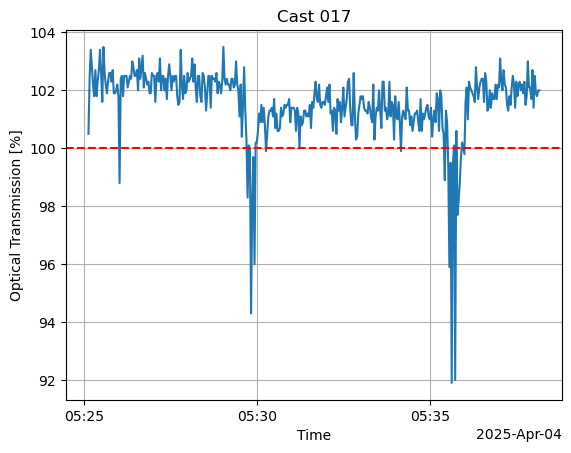

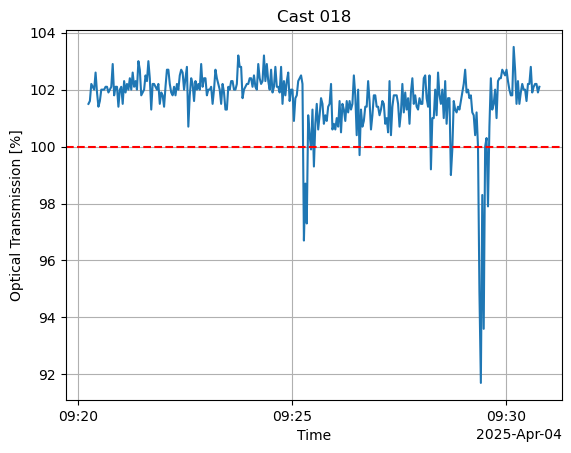

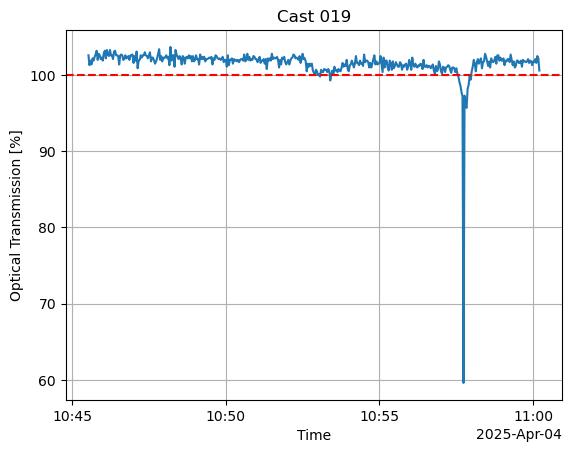

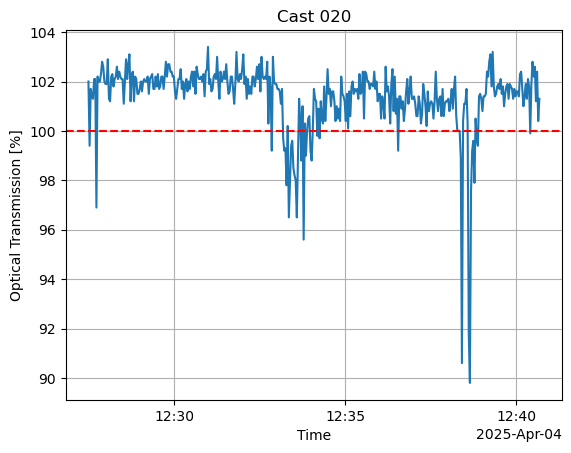

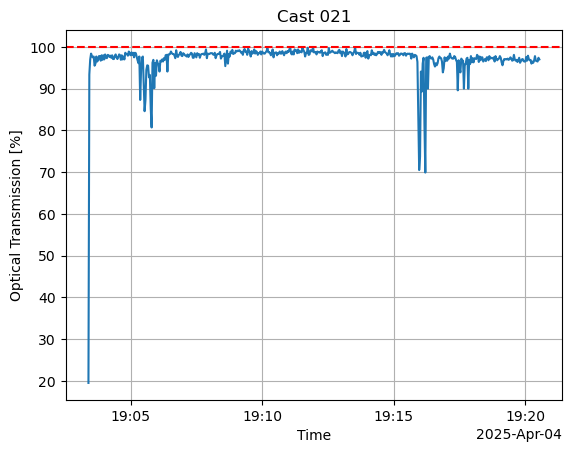

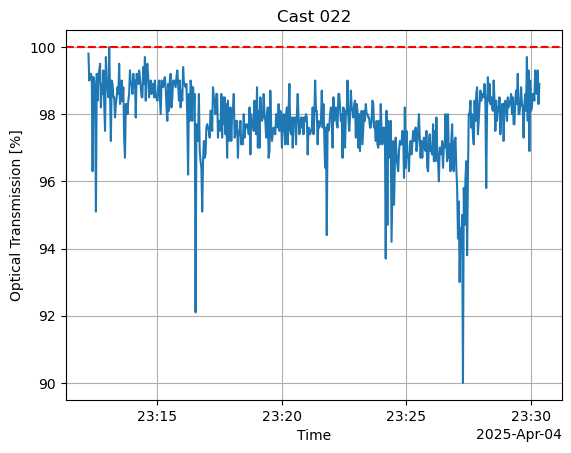

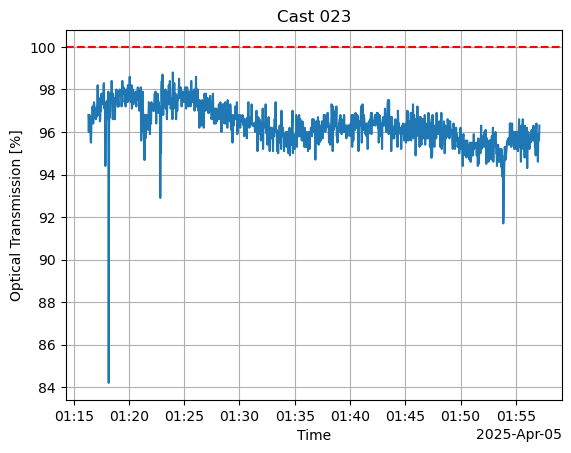

In [9]:
# Plot optical transmission for all leg 2 casts
leg = "a"
casts = np.arange(1, 24)
# leg = "b"
# casts = np.delete(np.arange(1, 25), [0, 12, 21])
casts = casts.astype(str)

for n in casts:
    castnum = n.rjust(3,"0")
    cast_ds = load_lisst(castnum, csvhdr, leg=leg)
    fig, ax = optical_transmission_plot(cast_ds, castnum)
    fig.savefig(f"./figures/ar87{leg}_cast{castnum}_lisst_transmission.png")

In [34]:
casts.astype(str)

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '14', '15', '16', '17', '18', '19', '20', '21', '23', '24'],
      dtype='<U21')

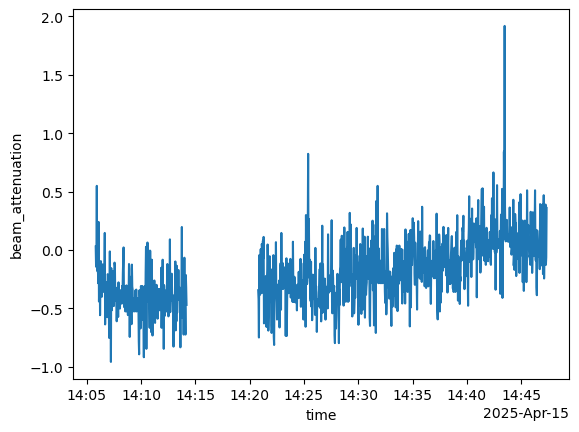

In [21]:
beam_attenuation = cast23_ds.beam_attenuation.where(cast23_ds["depth"]>=0, np.nan)
beam_attenuation.plot()

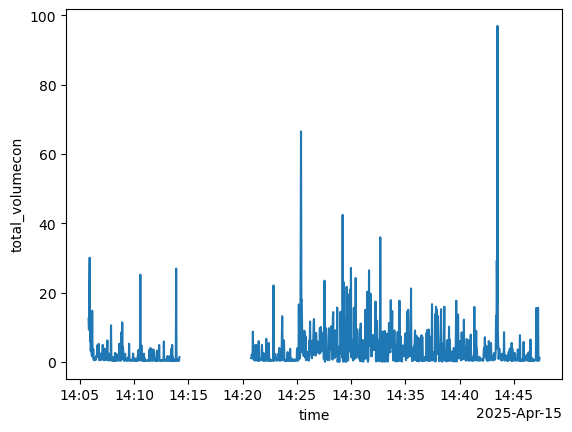

In [43]:
total_volume = cast23_ds.total_volumecon.where(cast23_ds["depth"]>=0)
total_volume.plot()

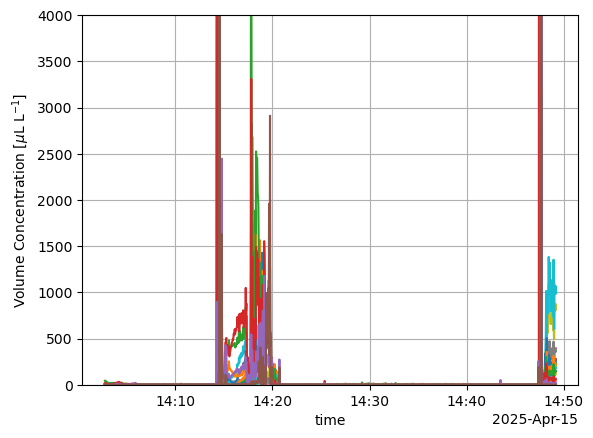

In [ ]:
# Plot the volume concentration time series
# for each of the 36 detector bins
fig, ax = plt.subplots()

for k in cast23_ds.variables:
    if re.search("volumecon[0-9]+", k):
        cast23_ds[k].plot.line(ax=ax)

# TO-DO: use twiny (I forget the exact usage)
# to plot mean particle size over this on the
# right y-axis. Based on the mean particle size,
# we can estimate what the maximum volume concentration
# should be at that point in the cast. 
# - maybe plot this as estimated max volume
# concentration on left y-axis

ax.set_ylim([0, 4000])
ax.set_ylabel(r"Volume Concentration [$\mu$L L$^{-1}$]")
ax.grid()

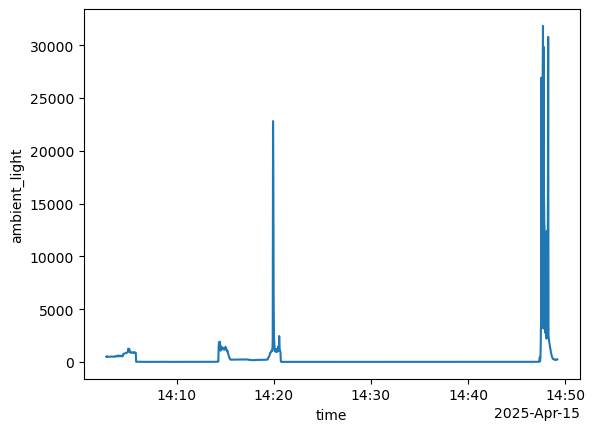

In [44]:
cast23_ds.ambient_light.plot()

#### Evaluate quality tests on LISST data
The recommended QC procedure for optical transmission from Sequoia Scientific is encapsulated by running the IOOS QARTOD gross range test with both "fail" and "of interest/suspect" spans coming from the instrument manual. Other parameters are QC'ed with a gross range test which checks for values that fall within the vendor-defined instrument limits.